# 血糖値　回帰予測
## dropout, 6layers, over fitting

### いけたかもしれない

In [4]:
# モジュールのインポート
%load_ext autoreload

%autoreload 2
import time
import matplotlib.pyplot as plt
import pandas
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples

import numpy
import os
import glob
import sys
from pathlib import Path

from chainer import Sequential
import easy_chainer


In [21]:
# 4層NN(入力→中間，中間→出力)
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [51]:
# 5層以上NN
# dropout
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_units)  # n_units -> n_units
            self.l4 = L.Linear(None, n_units)  # n_units -> n_out
            self.l5 = L.Linear(None, n_out)
           
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h = F.dropout(h1)                       # dropout層を作る（試験的に導入,検討を重ねる必要がある）
        h2 = F.relu(self.l2(h1))
        hh = F.dropout(h2)　　　　　　　　　　　# dropout層　batch normalizationと比較検討したい
        h3 = F.relu(self.l3(h2))
        kh = F.dropout(h3)　　　　　　　　　　　# dropout
        h4 = F.relu(self.l4(h3))
        return self.l5(h4)

In [10]:
# 5層以上NN
# Batch Normalization
class MLP2(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_units)  # n_units -> n_units
            self.l4 = L.Linear(None, n_units)    # n_units -> n_out
            self.l5 = L.Linear(None, n_out)
            bnorm1 = L.BatchNormalization()
            bnorm2 = L.BatchNormalization()
            bnorm3 = L.BatchNormalization()
            self.train = True


    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h = bnorm1(h1)                       # batch normalization層を作る（試験的に導入,検討を重ねる必要がある）
        h2 = F.relu(self.l2(h1))
        h = F.dropout(h2, 0.5)                       # batch normalization
        h3 = F.relu(self.l3(h2))
        kh = F.dropout(h3)                      # batch normalization
        h4 = F.relu(self.l4(h3))
        l2norm = F.normalization(h4)
        return self.l5(l2norm)

In [3]:
# データの読み込み 10,000datas
data, teach = easy_chainer.load_Data("/home/fiber_classifier/Desktop/data_oono/wrist_height_length_random 2.xls")
data = data.astype(numpy.float32)
teach = teach
print(teach)

[ 93. 129. 149. 194. 135. 140. 232. 172. 110.  94. 165. 175. 192. 219.
 203. 171.  97. 177. 103. 107. 140. 119.  94. 108. 112. 210. 159.  94.
  93. 166. 171. 121. 142. 108. 109. 105. 122. 160. 100.  94. 150. 146.
 160.  94. 208. 133. 104. 158. 206. 222. 167. 188. 105. 103.  97. 163.
 169. 111. 109. 167. 205.]


In [18]:
# 1,000datas
data, teach = easy_chainer.load_Data("/home/fiber_classifier/Desktop/wrist_height_length_random_1000.xls")
data = data.astype(numpy.float32)
teach = teach
print(teach)

[194.  97. 150. 222. 109. 165. 135. 205. 122. 172. 167. 142. 111. 160.
  93. 119. 160. 103. 133. 149. 100. 129. 219.  94.  93.  94. 232.  94.
 108. 105. 105. 188. 107. 171. 206. 167. 208. 163. 169.  97. 166. 192.
 158. 175. 171. 103. 140. 146.  94. 109. 121. 177. 159. 108. 210.  94.
 203. 104. 140. 112.]


In [19]:
print(data.shape)

(1000, 60)


In [20]:
# 回帰させるときに必要（分類はint型）
teach = teach.astype(numpy.float32)

In [21]:
id_all = numpy.arange(1, len(teach) + 1, 1).astype(numpy.int32) - 1
print(id_all)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


In [22]:
# 訓練データ
id_train = numpy.random.choice(id_all, 50, replace=False) #重複なし
print(id_train)

[55 50 58 45 43 15 48 12 20 13 31 34  9 59  4 24 40 14 39 56 41  1 23 38
 32 19 28  8 37 36 22 52 17 49  6 46 53 16 30 33 26 47 11  3 29 44 54 25
  5  7]


In [24]:
# テストデータ
id_test = numpy.delete(id_all, id_train)
print(id_test)

[ 0  2 10 18 21 27 35 42 51 57]


In [119]:
teach[id_train]

array([ 94., 121., 140., 103., 175., 119.,  94., 111., 100., 160., 188.,
       206., 172., 112., 109.,  93., 166.,  93.,  97., 203., 192.,  97.,
        94., 169., 107., 149., 108., 122., 163., 208., 219., 159., 103.,
       109., 135., 140., 108., 160., 105., 171., 232., 146., 142., 222.,
       105., 171., 210.,  94., 165., 205.], dtype=float32)

In [93]:
x_train, y_train = data[:, id_train], teach[id_train]
x_test, y_test = data[:, id_test], teach[id_test]

In [94]:
train = tuple_dataset.TupleDataset(x_train.T, y_train.reshape(-1,1 ))
test = tuple_dataset.TupleDataset(x_test.T, y_test.reshape(-1, 1))

# batch size を決める　全データを使うならバッチ学習　使わないならミニバッチ学習（SGDとかが効いてくる）
train_iter = chainer.iterators.SerialIterator(train, 50)
test_iter = chainer.iterators.SerialIterator(test, 10, repeat=False, shuffle=False)

In [95]:
# model 決定　1000ノード　1出力
net = MLP2(1000, 1)
model = L.Classifier(net,
                     lossfun=F.mean_squared_error,
                     accfun=F.r2_score)
model.compute_accuracy = False



In [96]:
# if using GPU
def parse_device(args):
    gpu = None
    if args.gpu is not None:
        gpu = args.gpu
    elif re.match(r'(-|\+|)[0-9]+$', args.device):
        gpu = int(args.device)

    if gpu is not None:
        if gpu < 0:
            return chainer.get_device(numpy)
        else:
            import cupy
            return chainer.get_device((cupy, gpu))

    return chainer.get_device(args.device)

In [97]:
# 最適化方法
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [98]:
# 学習回数（epoch）とかを決める
updater = training.updaters.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (8000, 'epoch'), out="Result2019_oono/%s" % time.strftime("%Y%m%d%H%M%S"))
out_directory = "./Result2019_oono/%s" % time.strftime("%Y%m%d_%H%M%S")

In [99]:
# オプションです

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# if args.resume:
#     # Resume from a snapshot
#     chainer.serializers.load_npz(args.resume, trainer)


In [101]:
# 訓練実行！
trainer.run()

# モデル保存
net.to_cpu()

chainer.serializers.save_hdf5("/home/fiber_classifier/Desktop/model.hdf" ,obj=net)

numpy.save(arr=id_test, file="/home/fiber_classifier/Desktop/test_id.npy"  )
numpy.save(arr=id_train, file="/home/fiber_classifier/Desktop/train_id.npy" )


epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           22330.5     21492.8                                                        0.270376      
2           21197       18377                                                          0.475915      
3           18184.5     12353.5                                                        0.676647      
4           12369.1     4068.9                                                         0.907033      
5           4412.31     3577.2                                                         1.10449       
6           4180.39     5980.25                                                        1.29829       
7           6572.33     1865.02                                                        1.49789       
8           2451.69     1491.18                                                        1.6766        
9           1982.38     2987.72                                                     

79          1367.33     892.392                                                        14.8636       
80          1361.03     886.127                                                        15.0698       
81          1355.54     882.423                                                        15.2509       
82          1352.14     879.166                                                        15.4346       
83          1347.96     875.558                                                        15.6153       
84          1342.18     873.461                                                        15.7919       
85          1337.48     871.864                                                        15.9688       
86          1333.76     868.122                                                        16.1423       
87          1328.9      863.258                                                        16.3185       
88          1323.54     859.5                                                     

155         574.86      1078.72                                                        28.8049       
156         502.717     1179.37                                                        28.9918       
157         454.995     1495.81                                                        29.1781       
158         506.447     1097.29                                                        29.3641       
159         563.382     1543.44                                                        29.5556       
160         492.795     1218.61                                                        29.7625       
161         430.865     1224.29                                                        29.97         
162         427.563     1576.12                                                        30.1509       
163         463.928     1175.71                                                        30.3367       
164         494.97      1628.85                                                   

231         266.303     1875.53                                                        46.2195       
232         248.998     1655.74                                                        46.3863       
233         234.146     1719.12                                                        46.5589       
234         228.068     1802.19                                                        46.7641       
235         231.607     1637.98                                                        46.9369       
236         240.35      1936.41                                                        47.1089       
237         250.144     1597.97                                                        47.2895       
238         265.571     2040.61                                                        47.4611       
239         276.919     1552.35                                                        47.6347       
240         302.471     2117.18                                                   

307         184.724     1941.3                                                         60.2845       
308         208.962     1602.18                                                        60.4493       
309         251.237     2097.6                                                         60.6163       
310         261.432     1554.82                                                        60.7831       
311         259.688     1928.58                                                        60.9494       
312         214.719     1674.9                                                         61.6311       
313         185.193     1669.08                                                        61.7937       
314         186.155     1929.82                                                        61.948        
315         209.601     1602.93                                                        62.1147       
316         234.725     1996.68                                                   

386         164.125     1797.28                                                        74.5959       
387         159.9       1746.26                                                        74.7756       
388         158.1       1754.53                                                        74.9569       
389         157.664     1794.44                                                        75.1313       
390         158.012     1734.19                                                        75.3101       
391         159.237     1856.02                                                        76.0536       
392         162.39      1683.17                                                        76.2242       
393         171.095     1961.33                                                        76.3972       
394         185.648     1581.04                                                        76.5674       
395         223.158     2159.18                                                   

462         215.034     2066.26                                                        88.6599       
463         235.06      1511.66                                                        88.8594       
464         276.291     2085.75                                                        89.0256       
465         272.582     1503.4                                                         89.1903       
466         269.838     1892.16                                                        89.3925       
467         208.463     1620.61                                                        89.5669       
468         158.839     1620.51                                                        89.7352       
469         157.309     1848.74                                                        89.9004       
470         192.69      1520.28                                                        90.0683       
471         219.354     1932.41                                                   

538         181.33      2000.3                                                         102.409       
539         197.438     1535.36                                                        102.592       
540         223.491     2024.14                                                        102.76        
541         219.518     1528.52                                                        102.949       
542         217.015     1897                                                           103.116       
543         175.989     1645.49                                                        103.281       
544         145.738     1708.11                                                        103.448       
545         138.041     1816.49                                                        103.617       
546         148.392     1590.79                                                        103.792       
547         168.12      1955.42                                                   

614         153.425     1959.26                                                        116.31        
615         168.197     1589.48                                                        116.473       
616         185.621     1957.86                                                        116.645       
617         186.39      1571.94                                                        116.817       
618         176.768     1831.64                                                        116.989       
619         151.695     1671.76                                                        117.16        
620         132.345     1667.3                                                         117.331       
621         132.404     1831.6                                                         117.503       
622         146.749     1593.91                                                        117.705       
623         160.998     1918.43                                                   

693         174.774     1863.72                                                        130.324       
694         146.852     1655.86                                                        130.528       
695         125.488     1675.92                                                        130.707       
696         121.194     1756.82                                                        130.886       
697         127.979     1577.99                                                        131.065       
698         142.133     1905.84                                                        131.246       
699         156.518     1587.47                                                        131.449       
700         167.181     1946.16                                                        131.66        
     total [####..............................................]  8.75%
this epoch [..................................................]  0.00%
       700 iter, 700 epoch / 8000 epochs
 

769         118.627     1753.92                                                        146.63        
770         118.995     1610.03                                                        146.847       
771         130.588     1845.49                                                        147.065       
772         141.558     1571.41                                                        147.283       
773         144.155     1848.62                                                        147.502       
774         138.218     1611.85                                                        147.721       
775         129.781     1800.61                                                        147.941       
776         122.578     1680.01                                                        148.162       
777         116.498     1720.17                                                        148.395       
778         113.883     1733.92                                                   

845         170.023     1543.2                                                         165.024       
846         151.203     1778.07                                                        165.266       
847         122.876     1699.58                                                        165.512       
848         110.435     1614.5                                                         165.751       
849         119.559     1837.77                                                        165.992       
850         137.247     1532.45                                                        166.231       
851         150.981     1876.56                                                        166.475       
852         145.441     1582.77                                                        166.716       
853         131.96      1803.99                                                        166.989       
854         117.056     1714.96                                                   

921         136.275     1592.42                                                        182.896       
922         121.132     1708.19                                                        183.104       
923         109.222     1673.22                                                        183.312       
924         105.025     1601.02                                                        183.518       
925         112.363     1843.84                                                        183.723       
926         128.272     1562.47                                                        183.933       
927         149.019     1943.16                                                        184.148       
928         164.406     1548.54                                                        184.354       
929         175.503     1849.87                                                        184.559       
930         158.01      1550.09                                                   

1000        98.8576     1720.51                                                        201.369       
     total [######............................................] 12.50%
this epoch [..................................................]  0.00%
      1000 iter, 1000 epoch / 8000 epochs
    4.9259 iters/sec. Estimated time to finish: 0:23:41.056406.
1001        100.107     1618.72                                                        201.578       
1002        102.799     1767.64                                                        201.787       
1003        107.722     1569.31                                                        201.995       
1004        115.896     1823.59                                                        202.205       
1005        128.948     1527.41                                                        202.43        
1006        145.865     1860.23                                                        202.636       
1007        157.461     1501.75       

1076        146.524     1568.82                                                        217.981       
1077        111.65      1457.82                                                        218.208       
1078        150.875     1909.21                                                        218.415       
1079        202.585     1408.45                                                        218.626       
1080        241.021     1948.09                                                        218.834       
1081        196.709     1494.4                                                         219.052       
1082        151.217     1669.57                                                        219.268       
1083        111.754     1658.86                                                        219.512       
1084        111.802     1499.01                                                        219.737       
1085        138.749     1824.16                                                   

1152        172.89      1492.38                                                        234.197       
1153        155.394     1673.34                                                        234.41        
1154        108.279     1633.96                                                        234.623       
1155        100.747     1461.44                                                        234.835       
1156        135.169     1817.63                                                        235.049       
1157        157.26      1435.71                                                        235.262       
1158        148.81      1703.64                                                        235.474       
1159        115.785     1586.66                                                        235.687       
1160        94.7405     1549.75                                                        235.899       
1161        104.919     1787.02                                                   

1228        199.392     1419.91                                                        252.403       
1229        238.715     1679.41                                                        252.618       
1230        174.229     1435.06                                                        252.832       
1231        107.002     1478.22                                                        253.061       
1232        98.2445     1834.67                                                        253.281       
1233        156.689     1383.46                                                        253.511       
1234        249.574     2136.77                                                        253.742       
1235        301.788     1398.11                                                        253.964       
1236        375.571     1681.53                                                        254.177       
1237        233.423     1253.08                                                   

1304        84.1422     1590                                                           269.169       
1305        83.8312     1643.44                                                        269.382       
1306        85.2723     1568.55                                                        269.596       
1307        88.1555     1681.95                                                        269.809       
1308        91.3309     1521.06                                                        270.024       
1309        96.1045     1701.54                                                        270.24        
1310        102.151     1493.21                                                        270.458       
1311        107.783     1694.2                                                         270.672       
1312        108.054     1490.6                                                         270.886       
1313        108.389     1685.64                                                   

1383        79.1761     1611.15                                                        287.236       
1384        80.9838     1525.78                                                        287.46        
1385        83.6713     1632.49                                                        287.677       
1386        85.4556     1526.04                                                        287.898       
1387        84.438      1626                                                           288.119       
1388        80.9779     1569.35                                                        288.337       
1389        77.9369     1595.7                                                         288.557       
1390        77.0867     1603.47                                                        288.775       
1391        77.5504     1547.28                                                        288.998       
1392        78.7125     1614.43                                                   

1459        88.0942     1630.61                                                        303.963       
1460        86.2904     1508.29                                                        306.191       
1461        81.0553     1570.12                                                        306.413       
1462        76.7537     1563.85                                                        306.635       
1463        75.7636     1518.05                                                        306.855       
1464        78.6119     1618.32                                                        307.077       
1465        81.1902     1510.79                                                        307.295       
1466        81.0183     1598.93                                                        307.513       
1467        78.1681     1526.55                                                        307.734       
1468        75.2754     1554.13                                                   

1535        132.286     1488.54                                                        322.884       
1536        91.9734     1750.06                                                        323.108       
1537        146.019     1364.41                                                        323.33        
1538        203.519     1764.62                                                        323.553       
1539        146.823     1500.36                                                        323.775       
1540        92.8903     1436.13                                                        323.994       
1541        107.846     1676.71                                                        324.217       
1542        136.008     1402.15                                                        324.439       
1543        118.491     1464.82                                                        324.667       
1544        90.5882     1610.17                                                   

1611        69.3991     1583.09                                                        340.001       
1612        68.5695     1503.86                                                        340.224       
1613        69.2144     1592.21                                                        340.449       
1614        70.798      1464.96                                                        340.674       
1615        74.5464     1607.09                                                        340.898       
1616        79.9766     1413.3                                                         341.122       
1617        92.1276     1671.96                                                        341.348       
1618        104.79      1382.15                                                        341.572       
1619        135.068     1769.1                                                         341.796       
1620        163.685     1321.4                                                    

1690        62.6649     1543.51                                                        357.968       
1691        63.9479     1450.97                                                        358.192       
1692        63.2006     1502.77                                                        358.418       
1693        60.8661     1468.98                                                        358.643       
1694        59.2661     1465.48                                                        358.868       
1695        59.5802     1516.51                                                        359.094       
1696        60.9347     1461.16                                                        359.32        
1697        62.1459     1541.19                                                        359.545       
1698        61.668      1475.75                                                        359.769       
1699        60.2284     1511.33                                                   

1766        144.646     1342.54                                                        375.33        
1767        135.567     1742.06                                                        375.556       
1768        137.526     1271.32                                                        375.789       
1769        162.272     1806.36                                                        376.02        
1770        185.681     1192.44                                                        376.245       
1771        282.276     1884.61                                                        376.471       
1772        253.603     1217.57                                                        376.695       
1773        248.421     1756.44                                                        376.922       
1774        164.943     1302.15                                                        377.148       
1775        129.533     1555.46                                                   

1842        52.5994     1424.16                                                        395.143       
1843        53.0938     1382.54                                                        395.371       
1844        53.3125     1442.52                                                        395.598       
1845        52.8654     1412.19                                                        395.826       
1846        52.1747     1454.51                                                        396.06        
1847        51.4519     1439.29                                                        396.291       
1848        50.9702     1436.57                                                        396.524       
1849        50.6538     1434.41                                                        396.762       
1850        50.372      1406.95                                                        396.991       
1851        50.479      1435.17                                                   

1918        53.2462     1415.24                                                        413.227       
1919        50.0315     1340.48                                                        413.458       
1920        47.5576     1414.13                                                        413.689       
1921        46.0021     1363.23                                                        413.919       
1922        44.7387     1386.43                                                        414.15        
1923        44.1165     1369.39                                                        414.382       
1924        44.0455     1374.13                                                        414.615       
1925        43.5012     1390.15                                                        414.851       
1926        43.79       1364.86                                                        415.084       
1927        44.4854     1397.29                                                   

1997        62.0253     1446.91                                                        431.543       
1998        63.3028     1370.12                                                        431.776       
1999        58.647      1400.06                                                        432.008       
2000        55.0043     1434.43                                                        432.239       
     total [############......................................] 25.00%
this epoch [..................................................]  0.00%
      2000 iter, 2000 epoch / 8000 epochs
    4.5938 iters/sec. Estimated time to finish: 0:21:46.101995.
2001        57.0753     1356.29                                                        432.472       
2002        57.7483     1397.02                                                        432.703       
2003        54.9065     1377.8                                                         432.934       
2004        53.3885     1363.71       

2073        55.7785     1441.35                                                        449.193       
2074        64.1737     1245.48                                                        449.42        
2075        69.822      1402.08                                                        449.644       
2076        65.8811     1261.77                                                        449.87        
2077        57.1207     1387.54                                                        450.095       
2078        47.554      1370.77                                                        450.321       
2079        43.0627     1349.11                                                        450.59        
2080        44.84       1410.65                                                        450.817       
2081        51.1312     1236.08                                                        451.042       
2082        60.777      1406.07                                                   

2149        89.3321     1112.9                                                         466.545       
2150        134.627     1429.3                                                         466.773       
2151        135.278     1072.53                                                        466.998       
2152        104.368     1381.23                                                        467.224       
2153        46.7289     1531.38                                                        467.451       
2154        53.0463     1324.38                                                        467.678       
2155        113.877     1797.08                                                        467.905       
2156        228.471     1072.83                                                        468.131       
2157        396.583     1250.91                                                        468.355       
2158        180.509     1087.73                                                   

2225        40.4107     1315.75                                                        484.641       
2226        40.7879     1347.42                                                        487.966       
2227        41.8397     1234.88                                                        488.194       
2228        44.2751     1306.71                                                        488.423       
2229        45.9826     1197.34                                                        488.651       
2230        45.6901     1325.06                                                        488.877       
2231        45.8612     1241.61                                                        489.106       
2232        44.2691     1343.3                                                         489.334       
2233        43.461      1263.68                                                        489.562       
2234        41.38       1315.78                                                   

2301        76.9472     1630.53                                                        505.72        
2302        90.0886     1318.71                                                        505.949       
2303        84.8967     1494.5                                                         506.178       
2304        60.8209     1352.39                                                        506.405       
2305        49.9571     1304.44                                                        506.634       
2306        52.7195     1495.33                                                        506.863       
2307        63.176      1321.39                                                        507.092       
2308        61.3311     1458.23                                                        507.324       
2309        48.722      1425.26                                                        507.554       
2310        47.5165     1357.1                                                    

2379        39.1764     1212.24                                                        524.463       
2380        45.7842     1386.02                                                        524.744       
2381        52.49       1197.98                                                        525.001       
2382        59.442      1406.73                                                        525.282       
2383        62.331      1197.45                                                        525.543       
2384        60.4425     1378.97                                                        525.776       
2385        52.9595     1226.71                                                        526.009       
2386        41.5839     1315.88                                                        526.242       
2387        33.9449     1325.01                                                        526.474       
2388        33.0495     1253.94                                                   

2455        44.2657     1188.31                                                        542.458       
2456        40.8998     1293.52                                                        542.691       
2457        36.3192     1221.04                                                        542.924       
2458        31.8619     1273.43                                                        543.158       
2459        29.5354     1273.26                                                        543.391       
2460        29.4342     1238.32                                                        543.624       
2461        31.064      1306.05                                                        543.861       
2462        35.3418     1180.25                                                        544.094       
2463        42.1352     1359.69                                                        544.328       
2464        53.7025     1154.95                                                   

2531        44.6766     1345.62                                                        560.4         
2532        39.3844     1290.3                                                         560.636       
2533        45.0417     1405.83                                                        560.872       
2534        44.5857     1338.31                                                        561.107       
2535        37.4763     1317.6                                                         561.344       
2536        38.6522     1376.28                                                        561.58        
2537        42.321      1271.34                                                        561.815       
2538        38.0536     1287.93                                                        562.062       
2539        35.9104     1312.34                                                        562.297       
2540        37.5149     1266.68                                                   

2607        28.981      1316.36                                                        578.511       
2608        29.5738     1263.4                                                         578.749       
2609        30.7235     1334.73                                                        578.995       
2610        32.2801     1261.61                                                        579.234       
2611        33.2545     1356.92                                                        579.477       
2612        33.8259     1255.88                                                        579.717       
2613        32.7674     1330.26                                                        579.954       
2614        30.8272     1274.16                                                        580.195       
2615        28.8915     1301.84                                                        580.439       
2616        28.1816     1318.35                                                   

2686        36.1189     1388.07                                                        597.407       
2687        45.0638     1146.72                                                        597.645       
2688        51.3876     1341.09                                                        597.885       
2689        51.7357     1194.84                                                        598.123       
2690        47.7663     1411.77                                                        598.362       
2691        40.354      1255.79                                                        598.6         
2692        33.7089     1306.19                                                        598.843       
2693        29.442      1246.71                                                        599.084       
2694        27.1959     1251.3                                                         599.325       
2695        26.7688     1317.53                                                   

2762        31.6691     1215.3                                                         615.811       
2763        34.2408     1337.08                                                        616.053       
2764        38.3348     1150.01                                                        616.295       
2765        43.3699     1357.91                                                        616.535       
2766        45.3385     1185.01                                                        620.584       
2767        45.7287     1342.88                                                        620.825       
2768        41.3355     1178.92                                                        621.067       
2769        34.7993     1299.87                                                        621.308       
2770        27.0025     1277.23                                                        621.553       
2771        23.7178     1237.55                                                   

2838        34.7234     1145.59                                                        637.974       
2839        41.6153     1357.66                                                        638.218       
2840        48.5277     1172.82                                                        638.46        
2841        54.1445     1305.21                                                        638.701       
2842        54.9708     1140.44                                                        638.942       
2843        49.4765     1412.76                                                        639.185       
2844        43.0731     1181.18                                                        639.425       
2845        35.0569     1280.56                                                        639.666       
2846        28.4915     1277.73                                                        639.908       
2847        25.0393     1262.5                                                    

2914        22.2813     1294.85                                                        656.814       
2915        22.9965     1219.65                                                        657.061       
2916        23.9693     1285.19                                                        657.305       
2917        25.4368     1202.84                                                        657.555       
2918        26.8491     1297.23                                                        657.802       
2919        27.5181     1191.42                                                        658.046       
2920        28.0018     1308.51                                                        658.293       
2921        27.9293     1180.67                                                        658.539       
2922        28.1448     1284.8                                                         658.788       
2923        28.9682     1196.67                                                   

2993        38.3965     1440.93                                                        676.316       
2994        48.0616     1177.8                                                         676.562       
2995        56.1171     1243.37                                                        676.809       
2996        53.0105     1161.68                                                        677.057       
2997        31.2115     1405.94                                                        677.304       
2998        24.5949     1436.88                                                        677.553       
2999        35.7197     1180.5                                                         677.804       
3000        55.186      1346.14                                                        678.051       
     total [##################................................] 37.50%
this epoch [..................................................]  0.00%
      3000 iter, 3000 epoch / 8000 epochs


3069        209.251     1715.65                                                        695.553       
3070        225.064     938.3                                                          695.803       
3071        216.294     1248.02                                                        696.052       
3072        74.6554     1346.74                                                        696.302       
3073        78.5539     1140.2                                                         696.553       
3074        203.111     1586.88                                                        696.81        
3075        181.536     1194.67                                                        697.061       
3076        72.1021     1251.77                                                        697.309       
3077        51.9857     1516.32                                                        697.558       
3078        131.748     1160.11                                                   

3145        22.7222     1294.32                                                        714.635       
3146        22.3481     1287.15                                                        714.888       
3147        22.2965     1282.4                                                         715.141       
3148        22.1998     1295.27                                                        715.391       
3149        22.216      1310.59                                                        715.641       
3150        22.3107     1296.79                                                        715.891       
3151        22.7329     1313.88                                                        716.142       
3152        22.7318     1288.01                                                        716.391       
3153        22.1834     1301.5                                                         716.642       
3154        21.7243     1305.94                                                   

3221        21.032      1268.58                                                        733.913       
3222        22.1102     1282.51                                                        734.173       
3223        24.2841     1201.63                                                        734.427       
3224        26.8065     1374.64                                                        734.687       
3225        29.5187     1245.22                                                        734.94        
3226        32.5287     1306.63                                                        735.192       
3227        33.9741     1173.27                                                        735.445       
3228        31.9673     1348.24                                                        735.699       
3229        25.6735     1282.43                                                        735.95        
3230        21.2877     1294.12                                                   

3300        25.2811     1363.79                                                        754.028       
     total [####################..............................] 41.25%
this epoch [..................................................]  0.00%
      3300 iter, 3300 epoch / 8000 epochs
    4.3513 iters/sec. Estimated time to finish: 0:18:00.132123.
3301        20.8542     1242.18                                                        754.288       
3302        20.9655     1303.32                                                        754.595       
3303        24.0459     1228.62                                                        754.906       
3304        26.5766     1329.18                                                        755.217       
3305        24.0123     1277.27                                                        755.527       
3306        23.5536     1294.89                                                        755.786       
3307        22.8112     1152.27       

3376        17.9243     1298.29                                                        773.763       
3377        18.6756     1248.8                                                         774.019       
3378        20.3901     1303.41                                                        774.276       
3379        23.0155     1223.51                                                        774.536       
3380        26.185      1312.67                                                        774.794       
3381        28.6237     1188.03                                                        775.052       
3382        30.0005     1370.71                                                        775.31        
3383        28.9863     1217.84                                                        775.571       
3384        26.32       1295.29                                                        775.829       
3385        22.0422     1295.91                                                   

3452        19.6714     1350.48                                                        798.287       
3453        24.8272     1405.06                                                        798.544       
3454        28.0846     1186.75                                                        798.803       
3455        31.3936     1279.75                                                        799.064       
3456        29.1104     1235.86                                                        799.321       
3457        22.3714     1295.04                                                        799.607       
3458        17.4727     1296.35                                                        799.863       
3459        17.4211     1255.07                                                        800.121       
3460        21.3224     1264.88                                                        800.38        
3461        27.2637     1159.3                                                    

3528        19.5958     1137.12                                                        818.105       
3529        23.7987     1398.2                                                         818.364       
3530        24.0105     1290.66                                                        818.623       
3531        25.5648     1253.25                                                        818.88        
3532        26.4153     1135.12                                                        819.138       
3533        30.6494     1339.16                                                        819.398       
3534        24.5601     1223.11                                                        819.657       
3535        26.5387     1379.62                                                        819.915       
3536        21.3133     1224.83                                                        820.173       
3537        20.3309     1192.16                                                   

3604        23.1885     1312.65                                                        837.877       
3605        22.0338     1235.77                                                        838.14        
3606        22.1016     1328.55                                                        838.401       
3607        22.4481     1168.66                                                        838.661       
3608        23.1878     1296.83                                                        838.923       
3609        21.2885     1264.41                                                        839.184       
3610        20.3867     1295.02                                                        839.446       
3611        19.8135     1221.77                                                        839.707       
3612        19.9791     1289.27                                                        839.973       
3613        19.6352     1231.17                                                   

3683        305.566     1471.54                                                        858.727       
3684        221.298     1499.78                                                        858.991       
3685        222.399     1267.49                                                        859.255       
3686        271.443     1535.72                                                        859.516       
3687        226.159     1398.5                                                         859.834       
3688        196.68      1283.03                                                        860.099       
3689        225.388     1563.59                                                        860.36        
3690        223.264     1356.88                                                        860.623       
3691        192.53      1378.58                                                        860.884       
3692        187.95      1577.6                                                    

3759        148.199     1557.41                                                        878.891       
3760        151.4       1673.17                                                        879.162       
3761        150.737     1577.32                                                        879.43        
3762        147.349     1631.67                                                        879.693       
3763        144.28      1626.54                                                        879.956       
3764        143.566     1575.04                                                        880.218       
3765        144.875     1656.37                                                        880.483       
3766        146.377     1540.11                                                        880.747       
3767        147.254     1635.3                                                         881.01        
3768        145.629     1552.81                                                   

3835        138.436     1604.5                                                         899.089       
3836        135.511     1612.78                                                        899.357       
3837        135.802     1546.56                                                        899.625       
3838        138.265     1653.36                                                        899.892       
3839        139.456     1549.69                                                        900.161       
3840        138.071     1630.42                                                        900.433       
3841        135.637     1593.7                                                         900.701       
3842        134.21      1600.91                                                        900.975       
3843        133.989     1629.33                                                        901.244       
3844        134.47      1569.66                                                   

3911        147.264     1462.79                                                        919.617       
3912        141.594     1624.02                                                        919.886       
3913        133.361     1537.41                                                        920.177       
3914        128.303     1558.48                                                        920.507       
3915        127.663     1617.29                                                        920.775       
3916        130.074     1497.99                                                        921.05        
3917        135.348     1680.47                                                        921.32        
3918        142.482     1441.81                                                        921.59        
3919        153.391     1718.98                                                        921.86        
3920        154.416     1422.1                                                    

3990        129.89      1510.88                                                        941.061       
3991        123.965     1644.77                                                        941.331       
3992        134.218     1449.45                                                        941.6         
3993        147.909     1743.28                                                        941.87        
3994        150.741     1446.79                                                        942.138       
3995        153.244     1683.2                                                         942.408       
3996        139.636     1472.84                                                        942.677       
3997        127.851     1549.54                                                        942.945       
3998        121.173     1585.67                                                        943.215       
3999        122.842     1472.68                                                   

4066        159.695     1678.39                                                        961.626       
4067        138.405     1465.71                                                        961.898       
4068        120.232     1536.98                                                        962.168       
4069        113.086     1642.49                                                        962.439       
4070        120.884     1458.04                                                        962.708       
4071        136.273     1742.89                                                        962.979       
4072        145.009     1425.63                                                        963.25        
4073        152.89      1716.72                                                        963.52        
4074        139.417     1463.44                                                        963.791       
4075        127.255     1611.47                                                   

4142        116.769     1725                                                           981.848       
4143        133.162     1412.65                                                        982.109       
4144        140.383     1682.17                                                        982.373       
4145        114.707     1531.14                                                        982.643       
4146        98.6371     1512.02                                                        982.907       
4147        100.828     1689.67                                                        983.17        
4148        114.134     1434.05                                                        983.434       
4149        133.013     1723.91                                                        983.698       
4150        124.696     1464.83                                                        983.962       
4151        110.486     1586.86                                                   

4218        85.9773     1516.71                                                        1007.83       
4219        85.9674     1611.86                                                        1008.09       
4220        91.7281     1441.96                                                        1008.36       
4221        99.1244     1643.46                                                        1008.62       
4222        97.9379     1461.83                                                        1008.88       
4223        91.7992     1568.37                                                        1009.15       
4224        84.5574     1521.41                                                        1009.42       
4225        83.5699     1469.21                                                        1009.68       
4226        86.2067     1630.6                                                         1009.95       
4227        90.5132     1450.82                                                   

4297        96.3533     1378.35                                                        1028.93       
4298        81.552      1394.9                                                         1029.2        
4299        79.0685     1570.26                                                        1029.47       
4300        86.297      1463.94                                                        1029.73       
     total [##########################........................] 53.75%
this epoch [..................................................]  0.00%
      4300 iter, 4300 epoch / 8000 epochs
    4.1538 iters/sec. Estimated time to finish: 0:14:50.752575.
4301        100.081     1769.21                                                        1030          
4302        104.553     1467.13                                                        1030.27       
4303        100.394     1594.23                                                        1030.54       
4304        85.4691     1426.93       

4373        104.215     1296.38                                                        1049.62       
4374        179.025     1857.02                                                        1049.89       
4375        158.78      1466.73                                                        1050.16       
4376        128.227     1662.3                                                         1050.43       
4377        76.1687     1608.27                                                        1050.7        
4378        73.9182     1403.53                                                        1050.97       
4379        100.067     1646.65                                                        1051.24       
4380        99.0237     1418.49                                                        1051.51       
4381        80.014      1512.03                                                        1051.78       
4382        66.0392     1602.95                                                   

4449        69.0434     1656.74                                                        1070.61       
4450        80.5237     1397.72                                                        1070.89       
4451        104.98      1758.23                                                        1071.17       
4452        110.518     1405.7                                                         1071.45       
4453        117.419     1681.9                                                         1071.74       
4454        89.2258     1439.65                                                        1072.02       
4455        71.0262     1549.53                                                        1072.3        
4456        58.7928     1546.16                                                        1072.58       
4457        56.7235     1452.52                                                        1072.87       
4458        60.9731     1615.7                                                    

4525        53.8173     1695.77                                                        1092.58       
4526        86.7939     1337.05                                                        1092.87       
4527        145.462     1697.16                                                        1093.15       
4528        130.839     1272.19                                                        1093.43       
4529        114.354     1419                                                           1093.72       
4530        65.9764     1517.18                                                        1094          
4531        75.7423     1370.02                                                        1094.3        
4532        116.01      1776.33                                                        1094.58       
4533        120.452     1427.94                                                        1094.86       
4534        121.702     1660.76                                                   

4601        76.415      1396.97                                                        1113.71       
4602        81.6197     1517.73                                                        1113.99       
4603        64.5718     1387.7                                                         1114.26       
4604        46.9441     1421.27                                                        1114.53       
4605        45.3973     1579.63                                                        1114.81       
4606        57.8021     1451.67                                                        1115.08       
4607        79.7548     1710.97                                                        1115.36       
4608        86.6527     1386.65                                                        1115.63       
4609        91.3215     1533.05                                                        1115.91       
4610        67.0112     1401.85                                                   

4679        45.9269     1457.55                                                        1135.31       
4680        43.8189     1538.93                                                        1135.59       
4681        41.2933     1523.99                                                        1135.86       
4682        40.2352     1527.77                                                        1136.14       
4683        39.1354     1543.59                                                        1136.41       
4684        40.3251     1485.37                                                        1136.7        
4685        42.2119     1566.57                                                        1136.97       
4686        44.5952     1445.3                                                         1137.25       
4687        48.866      1557.36                                                        1137.53       
4688        50.8141     1439.57                                                   

4755        78.8168     1415.18                                                        1156.62       
4756        134.215     1808.94                                                        1156.9        
4757        146.88      1362.94                                                        1157.18       
4758        171.284     1598.37                                                        1157.46       
4759        92.5208     1381.37                                                        1157.74       
4760        52.0901     1262.16                                                        1158.02       
4761        87.4377     1703.47                                                        1158.3        
4762        143.925     1412.68                                                        1158.58       
4763        249.336     1931.43                                                        1158.86       
4764        154.481     1338.52                                                   

4831        40.9183     1487.18                                                        1178.34       
4832        44.5202     1627.06                                                        1178.61       
4833        48.0011     1479.77                                                        1178.9        
4834        53.2861     1639.48                                                        1179.18       
4835        53.4928     1438.19                                                        1179.46       
4836        56.5714     1570.23                                                        1179.74       
4837        49.4026     1447.86                                                        1180.02       
4838        42.4999     1556.46                                                        1180.3        
4839        36.6017     1547.97                                                        1180.58       
4840        34.9557     1530.95                                                   

4907        52.455      1417.36                                                        1200.57       
4908        49.2826     1543.96                                                        1200.85       
4909        39.3289     1475.78                                                        1201.14       
4910        35.6001     1517.36                                                        1201.42       
4911        32.1752     1537.3                                                         1201.7        
4912        33.5348     1530.71                                                        1201.99       
4913        34.8758     1642.82                                                        1202.32       
4914        39.2867     1470.85                                                        1202.66       
4915        42.7775     1591.02                                                        1203          
4916        44.5818     1440.66                                                   

4986        31.1742     1518.02                                                        1223.42       
4987        32.3809     1465.62                                                        1223.71       
4988        35.1694     1577.71                                                        1223.99       
4989        40.2549     1412.96                                                        1224.27       
4990        44.9927     1579.94                                                        1224.56       
4991        44.9047     1490.6                                                         1224.84       
4992        44.1261     1655.42                                                        1225.13       
4993        38.9516     1503.4                                                         1225.41       
4994        36.6534     1597.21                                                        1225.7        
4995        33.4334     1497.98                                                   

5062        84.728      1467.89                                                        1245.69       
5063        154.856     1826.05                                                        1245.97       
5064        137.834     1467.77                                                        1246.26       
5065        179.437     1753.41                                                        1246.55       
5066        126.422     1500.88                                                        1246.84       
5067        63.0482     1369.7                                                         1247.12       
5068        76.1912     1489.34                                                        1247.41       
5069        102.482     1125.57                                                        1247.69       
5070        92.6361     1315.3                                                         1247.97       
5071        58.9316     1429.9                                                    

5138        52.0422     1580.63                                                        1267.54       
5139        42.2012     1448.91                                                        1267.83       
5140        32.5219     1470.99                                                        1268.11       
5141        29.4473     1527.98                                                        1268.4        
5142        33.6853     1442.78                                                        1268.69       
5143        42.429      1613.47                                                        1268.97       
5144        50.7973     1406.38                                                        1269.26       
5145        72.6011     1684.31                                                        1269.55       
5146        69.6954     1369.09                                                        1269.83       
5147        50.5168     1443.34                                                   

5214        32.7863     1427.15                                                        1289.38       
5215        43.1713     1620.87                                                        1289.67       
5216        43.1081     1449.11                                                        1289.95       
5217        39.8595     1571.77                                                        1290.24       
5218        29.4743     1537.56                                                        1290.53       
5219        26.2849     1487.91                                                        1290.82       
5220        29.7233     1599.58                                                        1291.1        
5221        37.1855     1441.37                                                        1291.39       
5222        45.8983     1620.39                                                        1291.68       
5223        42.3606     1444.11                                                   

5293        33.2789     1392.51                                                        1319.43       
5294        34.1881     1532.2                                                         1319.72       
5295        30.8739     1414.47                                                        1320.01       
5296        29.7378     1512.87                                                        1320.3        
5297        26.5198     1439.15                                                        1320.59       
5298        23.9149     1436.37                                                        1320.88       
5299        23.1049     1464.76                                                        1321.17       
5300        23.9622     1402.11                                                        1321.46       
     total [#################################.................] 66.25%
this epoch [..................................................]  0.00%
      5300 iter, 5300 epoch / 8000 epochs


5369        22.298      1460.1                                                         1341.54       
5370        23.0726     1474.37                                                        1341.83       
5371        21.9618     1485.96                                                        1342.12       
5372        22.767      1472.83                                                        1342.41       
5373        22.4398     1513.44                                                        1342.71       
5374        22.9962     1477.73                                                        1343          
5375        23.4142     1551.28                                                        1343.29       
5376        24.661      1436.07                                                        1343.59       
5377        28.0375     1569.74                                                        1343.88       
5378        31.0839     1413.77                                                   

5445        27.0224     1397                                                           1363.79       
5446        25.218      1513.49                                                        1364.08       
5447        22.5884     1467.6                                                         1364.38       
5448        21.0867     1457.78                                                        1364.67       
5449        20.8141     1540.38                                                        1364.96       
5450        23.9128     1393.66                                                        1365.26       
5451        26.6848     1533.48                                                        1365.55       
5452        31.0103     1333.58                                                        1365.84       
5453        37.4124     1587.35                                                        1366.13       
5454        40.8144     1356.74                                                   

5521        21.5041     1437.87                                                        1386.15       
5522        22.0976     1456.38                                                        1386.45       
5523        22.5735     1411.83                                                        1386.74       
5524        21.4873     1496.57                                                        1387.04       
5525        23.3568     1403.54                                                        1387.33       
5526        22.652      1477.3                                                         1387.63       
5527        20.8197     1436.65                                                        1387.92       
5528        20.9774     1489.19                                                        1388.21       
5529        20.6471     1423.81                                                        1388.51       
5530        20.8619     1485.66                                                   

5600        22.8465     1376.84                                                        1409.54       
     total [###################################...............] 70.00%
this epoch [..................................................]  0.00%
      5600 iter, 5600 epoch / 8000 epochs
    3.9541 iters/sec. Estimated time to finish: 0:10:06.959935.
5601        24.3084     1518.99                                                        1409.83       
5602        28.2923     1344.57                                                        1410.12       
5603        28.1081     1496.11                                                        1410.42       
5604        27.8012     1312.23                                                        1410.71       
5605        30.6557     1529                                                           1411          
5606        33.052      1334.67                                                        1411.29       
5607        32.3962     1527.18       

5676        22.4318     1507.55                                                        1432.02       
5677        22.9589     1384.41                                                        1432.31       
5678        30          1613.37                                                        1432.61       
5679        37.3273     1410.4                                                         1432.91       
5680        34.0153     1601.7                                                         1433.2        
5681        27.0949     1471.33                                                        1433.5        
5682        20.4006     1423.69                                                        1433.8        
5683        22.5958     1535.6                                                         1434.1        
5684        27.5338     1293.53                                                        1434.4        
5685        40.8614     1513.84                                                   

5752        27.0227     1348.99                                                        1454.72       
5753        27.0246     1520.36                                                        1455.02       
5754        30.5086     1321.86                                                        1455.32       
5755        32.9548     1532.9                                                         1455.62       
5756        29.5882     1335.6                                                         1455.92       
5757        26.5536     1475.43                                                        1456.22       
5758        21.7006     1371.52                                                        1456.52       
5759        20.4241     1432.33                                                        1456.82       
5760        16.7416     1444.31                                                        1457.12       
5761        19.6089     1397.2                                                    

5828        21.8848     1383.8                                                         1477.57       
5829        25.3743     1520.9                                                         1477.93       
5830        21.3295     1452.44                                                        1478.25       
5831        16.815      1409.46                                                        1478.55       
5832        19.3257     1488.64                                                        1478.85       
5833        23.1293     1293.35                                                        1479.15       
5834        26.196      1473.09                                                        1479.45       
5835        25.8108     1329.32                                                        1479.75       
5836        20.5466     1362.61                                                        1480.05       
5837        15.9894     1466.65                                                   

5904        60.3203     1646.18                                                        1501.69       
5905        47.6574     1335.41                                                        1502.05       
5906        33.7309     1435.55                                                        1502.36       
5907        20.1792     1624.16                                                        1502.66       
5908        36.1101     1291.76                                                        1502.97       
5909        65.5475     1682.51                                                        1503.27       
5910        50.6028     1354.64                                                        1503.57       
5911        28.8419     1446.91                                                        1503.87       
5912        17.5054     1594.26                                                        1504.17       
5913        31.5789     1299.6                                                    

5983        16.7993     1490.27                                                        1526.21       
5984        16.9217     1386.36                                                        1526.51       
5985        16.9198     1465.09                                                        1526.81       
5986        15.06       1406.94                                                        1527.11       
5987        17.7416     1480.73                                                        1527.42       
5988        14.1934     1440.78                                                        1527.72       
5989        15.2193     1466.51                                                        1528.03       
5990        13.7335     1432.74                                                        1528.33       
5991        13.6222     1409.26                                                        1528.64       
5992        14.115      1421.53                                                   

6059        37.2642     1307.41                                                        1549.38       
6060        22.2381     1350.53                                                        1549.74       
6061        16.8275     1551.89                                                        1550.05       
6062        29.6163     1300.87                                                        1550.37       
6063        47.7336     1637.83                                                        1550.67       
6064        52.7618     1224.17                                                        1550.97       
6065        59.7333     1538.95                                                        1551.28       
6066        33.0448     1375.79                                                        1551.59       
6067        21.5828     1309.48                                                        1551.89       
6068        32.6427     1724.55                                                   

6135        21.0217     1536.73                                                        1572.86       
6136        17.5406     1434.83                                                        1573.17       
6137        16.1247     1413.47                                                        1573.48       
6138        14.0404     1470.98                                                        1573.78       
6139        16.9592     1352.6                                                         1574.08       
6140        17.8452     1447.69                                                        1574.39       
6141        15.9356     1387.41                                                        1574.7        
6142        13.7439     1419.03                                                        1575          
6143        13.9091     1459.71                                                        1575.3        
6144        14.1167     1408.15                                                   

6211        16.2793     1380.1                                                         1596.11       
6212        17.7309     1512.72                                                        1596.42       
6213        16.7958     1382.46                                                        1596.72       
6214        14.6029     1485.56                                                        1597.03       
6215        14.0912     1429.51                                                        1597.33       
6216        13.2954     1491.61                                                        1597.63       
6217        12.6771     1483.1                                                         1597.94       
6218        12.6546     1467.41                                                        1598.24       
6219        12.1542     1456.31                                                        1598.55       
6220        12.7537     1419.01                                                   

6290        13.2203     1489.79                                                        1620.6        
6291        15.9403     1320.48                                                        1620.91       
6292        20.5192     1534.89                                                        1621.22       
6293        23.124      1318.68                                                        1621.53       
6294        25.0333     1560.38                                                        1621.84       
6295        25.3498     1329.6                                                         1622.14       
6296        29.1866     1549.69                                                        1622.45       
6297        21.7185     1418.34                                                        1622.76       
6298        18.3218     1443.76                                                        1623.08       
6299        12.6546     1436.33                                                   

6366        363.071     1095.63                                                        1644.27       
6367        494.173     1372.17                                                        1644.58       
6368        496.98      1125.74                                                        1644.89       
6369        302.972     1046.44                                                        1645.2        
6370        466.078     1031.72                                                        1645.51       
6371        171.697     2055.69                                                        1645.82       
6372        609.631     1268.82                                                        1646.13       
6373        282.206     1318.03                                                        1646.44       
6374        250.358     2042.04                                                        1646.75       
6375        441.064     1358.16                                                   

6442        38.3155     1437.1                                                         1667.94       
6443        37.8847     1443.41                                                        1668.25       
6444        37.6973     1424.83                                                        1668.56       
6445        37.3782     1429.06                                                        1668.87       
6446        37.0173     1431.83                                                        1669.24       
6447        36.7975     1421.06                                                        1669.56       
6448        36.5697     1437.34                                                        1669.87       
6449        36.1812     1443.53                                                        1670.18       
6450        35.9998     1419.14                                                        1670.5        
6451        36.1847     1457.51                                                   

6518        26.0188     1379.46                                                        1701.25       
6519        26.4574     1505.21                                                        1701.57       
6520        27.6942     1380.54                                                        1701.88       
6521        29.0269     1536.39                                                        1702.19       
6522        30.0963     1374.63                                                        1702.5        
6523        28.7804     1487.15                                                        1702.81       
6524        27.1182     1366.36                                                        1703.12       
6525        25.8292     1445.64                                                        1703.43       
6526        24.3499     1389.01                                                        1703.74       
6527        22.5959     1402.57                                                   

6597        18.2088     1479.59                                                        1725.93       
6598        18.7931     1390.35                                                        1726.25       
6599        21.4396     1542.02                                                        1726.56       
6600        24.3374     1347.02                                                        1726.88       
     total [#########################################.........] 82.50%
this epoch [..................................................]  0.00%
      6600 iter, 6600 epoch / 8000 epochs
    3.8049 iters/sec. Estimated time to finish: 0:06:07.944026.
6601        28.8543     1575.33                                                        1727.19       
6602        29.5151     1349.76                                                        1727.51       
6603        28.0934     1550.95                                                        1727.82       
6604        25.8179     1356.61       

6673        28.1309     1631.08                                                        1750.15       
6674        37.9275     1266.11                                                        1750.47       
6675        45.554      1593.86                                                        1750.78       
6676        34.2527     1353.75                                                        1751.1        
6677        25.2491     1482.01                                                        1751.41       
6678        17.748      1553.95                                                        1751.73       
6679        20.9742     1357.47                                                        1752.05       
6680        32.1062     1615.48                                                        1752.37       
6681        30.7649     1402.27                                                        1752.69       
6682        24.3502     1525.57                                                   

6749        15.4471     1510.75                                                        1775.3        
6750        15.122      1471.03                                                        1775.61       
6751        14.8997     1466.4                                                         1775.93       
6752        14.7955     1536.4                                                         1776.25       
6753        16.0603     1434.82                                                        1776.57       
6754        18.3111     1568.99                                                        1776.88       
6755        19.0259     1404.93                                                        1777.2        
6756        20.7039     1565.28                                                        1777.52       
6757        19.8161     1420.73                                                        1777.85       
6758        18.1593     1526.13                                                   

6825        16.6479     1419.88                                                        1799.54       
6826        21.7093     1606.88                                                        1799.85       
6827        24.5185     1387.2                                                         1800.17       
6828        24.1884     1560.23                                                        1800.49       
6829        18.8157     1472.9                                                         1800.81       
6830        13.7862     1480.95                                                        1801.13       
6831        14.6869     1589.35                                                        1801.44       
6832        18.533      1386.6                                                         1801.76       
6833        25.7156     1633.51                                                        1802.08       
6834        28.4051     1349.67                                                   

6901        21.09       1527.61                                                        1823.93       
6902        15.5752     1514.87                                                        1824.26       
6903        14.7577     1594.69                                                        1824.58       
6904        19.0195     1424.09                                                        1824.91       
6905        22.3231     1609.88                                                        1825.23       
6906        17.1444     1545.94                                                        1825.55       
6907        14.3254     1531.45                                                        1825.87       
6908        13.9611     1586.47                                                        1826.2        
6909        16.5878     1435.34                                                        1826.52       
6910        18.9598     1580.65                                                   

6979        12.9192     1484.68                                                        1848.99       
6980        14.16       1601.96                                                        1849.31       
6981        15.4251     1457.25                                                        1849.63       
6982        17.0367     1626.91                                                        1849.95       
6983        17.0504     1454.55                                                        1850.27       
6984        16.4114     1587.35                                                        1850.59       
6985        14.6463     1477.4                                                         1850.91       
6986        12.9799     1558.32                                                        1851.23       
6987        11.7815     1539.55                                                        1851.55       
6988        11.1845     1505.89                                                   

7055        15.5919     1442.96                                                        1873.34       
7056        17.6162     1706.19                                                        1873.66       
7057        31.8261     1424.99                                                        1873.98       
7058        40.3968     1731.31                                                        1874.3        
7059        32.6699     1461.9                                                         1874.63       
7060        20.9502     1516.17                                                        1874.95       
7061        14.9117     1710.1                                                         1875.27       
7062        22.0686     1472.45                                                        1875.59       
7063        28.8914     1718.58                                                        1875.91       
7064        24.5142     1502.88                                                   

7131        16.8458     1495.55                                                        1897.96       
7132        12.4177     1551.63                                                        1898.29       
7133        11.1336     1624.61                                                        1898.61       
7134        13.0937     1462.86                                                        1898.94       
7135        16.0407     1642.11                                                        1899.27       
7136        15.8923     1497.71                                                        1899.6        
7137        16.715      1642.54                                                        1899.92       
7138        14.1208     1499.51                                                        1900.33       
7139        11.2504     1530.66                                                        1900.72       
7140        10.8476     1579.57                                                   

7207        14.1228     1623.51                                                        1923.67       
7208        13.5217     1489.49                                                        1924          
7209        11.9838     1594.58                                                        1924.33       
7210        10.0342     1572.29                                                        1924.66       
7211        9.24916     1554.05                                                        1924.99       
7212        10.4455     1664.23                                                        1925.31       
7213        12.58       1490.33                                                        1925.64       
7214        16.3403     1688.35                                                        1925.97       
7215        21.7564     1390.96                                                        1926.3        
7216        28.0283     1723.31                                                   

7286        12.6826     1633.99                                                        1950.09       
7287        11.2335     1540.29                                                        1950.41       
7288        9.59335     1581.88                                                        1950.74       
7289        9.33185     1601.26                                                        1951.06       
7290        8.71074     1566.65                                                        1951.39       
7291        9.68966     1615.07                                                        1951.72       
7292        9.81737     1506.84                                                        1952.04       
7293        11.5096     1650.66                                                        1952.37       
7294        13.337      1495.19                                                        1952.7        
7295        14.9387     1692.34                                                   

7362        21.4819     1523.03                                                        1975.33       
7363        18.6984     1623.69                                                        1975.66       
7364        11.3857     1620.6                                                         1975.99       
7365        10.7878     1561.13                                                        1976.32       
7366        13.8209     1720.28                                                        1976.65       
7367        12.9636     1628.97                                                        1976.97       
7368        13.2948     1668.85                                                        1977.3        
7369        10.1708     1638.45                                                        1977.63       
7370        10.5481     1557.98                                                        1977.96       
7371        11.51       1643.65                                                   

7438        9.91111     1590.24                                                        2000.93       
7439        9.36731     1651.83                                                        2001.26       
7440        10.1419     1594.88                                                        2001.59       
7441        9.4146      1663.54                                                        2001.92       
7442        8.54326     1636.6                                                         2002.25       
7443        8.79149     1602.74                                                        2002.58       
7444        9.11144     1659.68                                                        2002.9        
7445        8.52695     1598.86                                                        2003.23       
7446        9.4719      1667.64                                                        2003.56       
7447        9.18249     1566.1                                                    

7514        183.454     1366.92                                                        2026.03       
7515        324.055     1795.88                                                        2026.36       
7516        103.218     1833.86                                                        2026.69       
7517        141.985     1219.45                                                        2027.02       
7518        233.244     2123.66                                                        2027.35       
7519        294.834     1187.39                                                        2027.68       
7520        149.165     1353.69                                                        2028.01       
7521        94.0998     1665.92                                                        2028.34       
7522        78.6164     1624.95                                                        2028.67       
7523        131.715     1962.34                                                   

7593        23.7656     1855.75                                                        2052.19       
7594        28.8288     1691.84                                                        2052.53       
7595        33.3344     1869.27                                                        2052.86       
7596        30.5876     1719.72                                                        2053.19       
7597        23.1202     1689.05                                                        2053.53       
7598        23.6121     1814.14                                                        2053.86       
7599        30.642      1632.09                                                        2054.2        
7600        37.8882     1879.09                                                        2054.59       
     total [###############################################...] 95.00%
this epoch [..................................................]  0.00%
      7600 iter, 7600 epoch / 8000 epochs


7669        20.1927     1694.36                                                        2078.08       
7670        20.7593     1804.24                                                        2078.41       
7671        19.3338     1707.72                                                        2078.74       
7672        17.509      1755.83                                                        2079.08       
7673        16.2225     1748.98                                                        2079.42       
7674        15.9251     1719.93                                                        2079.75       
7675        16.3067     1768.93                                                        2080.09       
7676        16.6822     1702.83                                                        2080.44       
7677        17.5303     1774.28                                                        2080.77       
7678        17.4897     1698.3                                                    

7745        23.3049     1731.82                                                        2103.78       
7746        26.1452     1521.67                                                        2104.11       
7747        30.4742     1721.44                                                        2104.45       
7748        23.6404     1551.58                                                        2104.79       
7749        16.7037     1592.96                                                        2105.12       
7750        14.1166     1672.06                                                        2105.46       
7751        17.2156     1531.82                                                        2105.8        
7752        27.1679     1755.82                                                        2106.13       
7753        32.4312     1478.04                                                        2106.47       
7754        40.1543     1725.42                                                   

7821        14.1843     1667.79                                                        2129.45       
7822        17.6562     1498.29                                                        2129.79       
7823        21.8834     1698.93                                                        2130.13       
7824        23.9328     1480.38                                                        2130.47       
7825        25.8286     1682.85                                                        2130.8        
7826        21.604      1520.25                                                        2131.15       
7827        16.1722     1609                                                           2131.48       
7828        11.3233     1618.07                                                        2131.82       
7829        11.532      1527.02                                                        2132.16       
7830        15.6764     1690.54                                                   

7900        10.1191     1568.26                                                        2156.61       
     total [#################################################.] 98.75%
this epoch [..................................................]  0.00%
      7900 iter, 7900 epoch / 8000 epochs
     3.648 iters/sec. Estimated time to finish: 0:00:27.411963.
7901        11.0451     1655.86                                                        2157.02       
7902        12.3541     1535.92                                                        2157.36       
7903        14.5919     1672.04                                                        2157.73       
7904        17.258      1502.31                                                        2158.08       
7905        20.3372     1694.72                                                        2158.42       
7906        20.8048     1503.6                                                         2158.75       
7907        19.2001     1662.28       

7976        27.1502     1623.25                                                        2193.9        
7977        37.8931     1644.32                                                        2194.24       
7978        21.9613     1478.29                                                        2194.57       
7979        37.0829     1507.46                                                        2194.91       
7980        21.1312     1654.69                                                        2195.25       
7981        21.1163     1673.94                                                        2195.59       
7982        30.9154     1712.37                                                        2195.93       
7983        21.9045     1630.69                                                        2196.27       
7984        17.6346     1644.98                                                        2196.61       
7985        18.7555     1615.03                                                   

In [102]:
# 検証（テストデータ）
# test_iter.reset()

# test_batch = test_iter.next()
# test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
# for i in range(10):
#    ref = test_ref[i]
#    pred = numpy.argmax(net(test_spc[i].reshape(1, -1)).data)
#    print("Ref: %d, Pred: %d %s" % (ref, pred, ref == pred))


Ref: 194, Pred: 0 [False]
Ref: 150, Pred: 0 [False]
Ref: 167, Pred: 0 [False]
Ref: 133, Pred: 0 [False]
Ref: 129, Pred: 0 [False]
Ref: 94, Pred: 0 [False]
Ref: 167, Pred: 0 [False]
Ref: 158, Pred: 0 [False]
Ref: 177, Pred: 0 [False]
Ref: 104, Pred: 0 [False]


In [103]:
# 検証（テストデータ）
test_iter.reset()

test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
for i in range(10):
    ref = test_ref[i]
    pred = net(test_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d %s" % (ref, pred, ref == pred))


Ref: 194, Pred: 236 [[False]]
Ref: 150, Pred: 175 [[False]]
Ref: 167, Pred: 140 [[False]]
Ref: 133, Pred: 124 [[False]]
Ref: 129, Pred: 121 [[False]]
Ref: 94, Pred: 93 [[False]]
Ref: 167, Pred: 155 [[False]]
Ref: 158, Pred: 104 [[False]]
Ref: 177, Pred: 198 [[False]]
Ref: 104, Pred: 204 [[False]]


In [123]:
# arr_ref:参照値，arr_pred:予測値（テストデータ）
arr_ref = numpy.array([194, 150, 167, 133, 129, 94, 167, 158, 177, 104])
arr_pred = numpy.array([236, 175, 140, 124, 121, 93, 155, 104, 198, 204])

In [ ]:
# 相関係数の算出＆表示
cor = numpy.corrcoef(arr_ref, arr_pred)[0, 1]
print(cor)

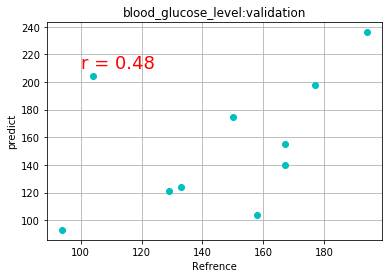

In [125]:
# 散布図を描画（r=に相関係数,保存する場所,色その他は適当に決める）
plt.plot(arr_ref, arr_pred, 'co')
plt.grid()
plt.xlabel('Refrence')
plt.ylabel('predict')
plt.title('blood_glucose_level:validation')
plt.text(100, 210, 'r = 0.48', fontsize=18, color='r')
plt.savefig('val_result_plot')
plt.show()

In [108]:
# 検証（訓練データ）
train_iter.reset()

train_batch = train_iter.next()
train_spc, train_ref = concat_examples(train_batch)  # Test Dataset
for i in range(50):
    cal_ref = train_ref[i]
    cal_pred = net(train_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d %s" % (cal_ref, cal_pred, ref == pred))

Ref: 160, Pred: 159 [[False]]
Ref: 210, Pred: 208 [[False]]
Ref: 160, Pred: 158 [[False]]
Ref: 146, Pred: 148 [[False]]
Ref: 119, Pred: 121 [[False]]
Ref: 232, Pred: 228 [[False]]
Ref: 159, Pred: 155 [[False]]
Ref: 192, Pred: 193 [[False]]
Ref: 172, Pred: 174 [[False]]
Ref: 107, Pred: 106 [[False]]
Ref: 94, Pred: 96 [[False]]
Ref: 97, Pred: 96 [[False]]
Ref: 165, Pred: 175 [[False]]
Ref: 111, Pred: 110 [[False]]
Ref: 171, Pred: 168 [[False]]
Ref: 93, Pred: 93 [[False]]
Ref: 109, Pred: 107 [[False]]
Ref: 103, Pred: 100 [[False]]
Ref: 122, Pred: 123 [[False]]
Ref: 140, Pred: 141 [[False]]
Ref: 142, Pred: 143 [[False]]
Ref: 100, Pred: 102 [[False]]
Ref: 203, Pred: 204 [[False]]
Ref: 108, Pred: 108 [[False]]
Ref: 163, Pred: 162 [[False]]
Ref: 208, Pred: 205 [[False]]
Ref: 206, Pred: 205 [[False]]
Ref: 94, Pred: 99 [[False]]
Ref: 188, Pred: 176 [[False]]
Ref: 219, Pred: 218 [[False]]
Ref: 175, Pred: 170 [[False]]
Ref: 97, Pred: 97 [[False]]
Ref: 205, Pred: 206 [[False]]
Ref: 166, Pred: 164 

In [83]:
# ミニバッチ学習のとき
#tarr_ref = numpy.array([205, 109, 166, 160, 140, 149, 109, 175, 140, 103])
#tarr_pred = numpy.array([186, 106, 157, 162, 151, 170, 117, 189, 138, 124])
#print('tarr_ref.shape = ', tarr_ref.shape , ',tarr_pred.shape=', tarr_pred.shape)

tarr_ref.shape =  (10,) ,tarr_pred.shape= (10,)


In [141]:
# バッチ学習のとき
tarr_ref = numpy.array([160, 210, 160, 146, 119, 232, 159, 192, 172, 107, 94, 97, 165, 111, 171, 93, 109, 103, 122, 
                        140, 142, 100, 203, 108, 163, 208, 206, 94, 188, 219, 175, 97, 205, 166, 149, 93, 140, 169,
                        222, 105, 109, 171, 108, 94, 135, 94, 105, 121, 103, 112])


tarr_pred = numpy.array([159, 208, 158, 148, 121, 228, 155, 193, 174, 106, 96, 96, 175, 110, 168, 93, 107, 100, 123, 141,
                   143, 102, 204, 108, 162, 205, 205, 99, 176, 218, 170, 97, 206, 164, 152, 95, 136, 176, 228, 104,
                   108, 169, 108, 94, 135, 98, 104, 120, 103, 108])

print('tarr_ref.shape = ', tarr_ref.shape , ',tarr_pred.shape=', tarr_pred.shape)

In [145]:
# 相関係数（訓練データセット）
tcor = numpy.corrcoef(tarr_ref, tarr_pred)[0, 1]
print(tcor)

0.996831506757341


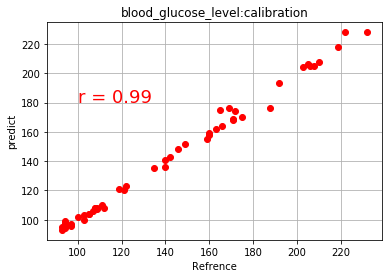

In [146]:
# 散布図の描画（相関係数とかは都度入れる）
plt.plot(tarr_ref, tarr_pred, 'ro')
plt.grid()
plt.xlabel('Refrence')
plt.ylabel('predict')
plt.title('blood_glucose_level:calibration')
plt.text(100, 180, 'r = 0.99', fontsize=18, color='r')
plt.savefig('cal_result_plot')
plt.show()